In [1]:
#Importing the necessary packages
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.tsa.stattools import adfuller

In [2]:
#Impoprting the data
riv_df = pd.read_csv('data/RIVN.csv')
riv_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
1,2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2,2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
3,2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
4,2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [3]:
#Checking the information
riv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       241 non-null    object 
 1   Open       241 non-null    float64
 2   High       241 non-null    float64
 3   Low        241 non-null    float64
 4   Close      241 non-null    float64
 5   Adj Close  241 non-null    float64
 6   Volume     241 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.3+ KB


In [4]:
riv_df = riv_df.set_index(pd.to_datetime(riv_df['Date']), drop=True)

In [5]:
riv_df

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2021-11-10,2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600
...,...,...,...,...,...,...,...
2022-10-19,2022-10-19,30.910000,31.760000,30.570000,31.500000,31.500000,10644900
2022-10-20,2022-10-20,31.100000,32.160000,30.370001,30.730000,30.730000,10633200
2022-10-21,2022-10-21,30.389999,32.000000,30.090000,31.920000,31.920000,9913300


In [6]:
#Converting date format to datetime for future plotting and calculations
riv_df.drop(columns = 'Date', inplace=True)

In [7]:
#Checking result
riv_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2021-11-10 to 2022-10-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       241 non-null    float64
 1   High       241 non-null    float64
 2   Low        241 non-null    float64
 3   Close      241 non-null    float64
 4   Adj Close  241 non-null    float64
 5   Volume     241 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.2 KB


In [8]:
#Checking information
riv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [9]:
#Checking for any missing values
riv_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
#Checking output
riv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [11]:
riv_df.index[0].month

11

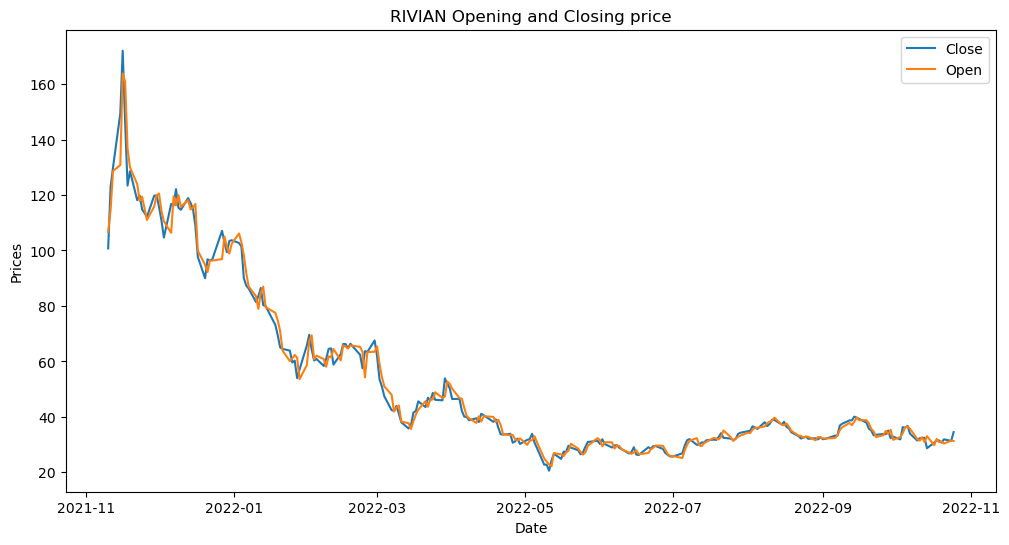

In [12]:
#Plotting the opening and closing price
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(riv_df['Close'])
plt.plot(riv_df['Open'])
plt.title('RIVIAN Opening and Closing price')
plt.legend(['Close', 'Open'])
plt.show()

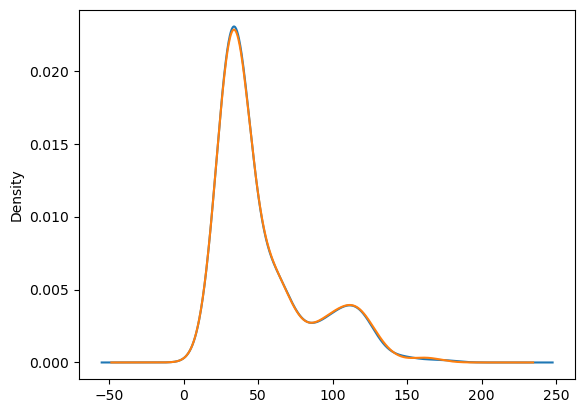

In [13]:
#Checking distribution of the dataset
riv_df_close = riv_df['Close']
riv_df_open = riv_df['Open']
riv_df_close.plot(kind='kde')
riv_df_open.plot(kind='kde');

In [14]:
#https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
#Calculating daily and monthly return
riv_daily_return = pd.DataFrame(riv_df['Adj Close'].pct_change())
riv_monthly_return=pd.DataFrame(riv_df['Adj Close'].resample('M').ffill().pct_change())

In [15]:
#Chceking output
riv_daily_return

,Adj Close
Date,
2021-11-10,NaN
2021-11-11,0.220987
2021-11-12,0.056590
2021-11-15,0.149365
2021-11-16,0.151647
...,...
2022-10-19,-0.004425
2022-10-20,-0.024444
2022-10-21,0.038724


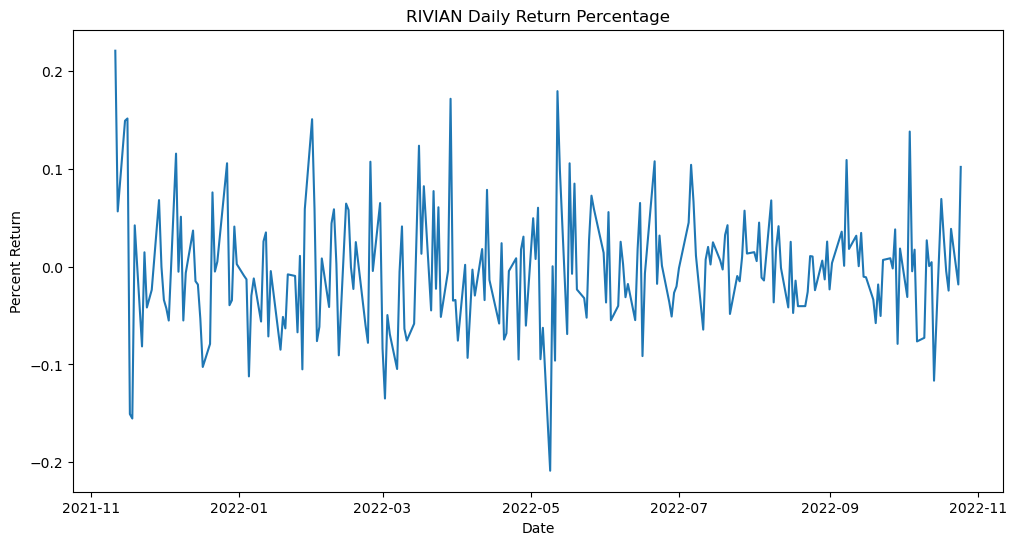

In [16]:
#Visualizing daily return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_daily_return)
plt.title('RIVIAN Daily Return Percentage')
plt.show()

In [17]:
#Checking output
riv_monthly_return

,Adj Close
Date,
2021-11-30,NaN
2021-12-31,-0.134185
2022-01-31,-0.365995
2022-02-28,0.027685
2022-03-31,-0.256365
2022-04-30,-0.398089
2022-05-31,0.038360
2022-06-30,-0.180255
2022-07-31,0.332556


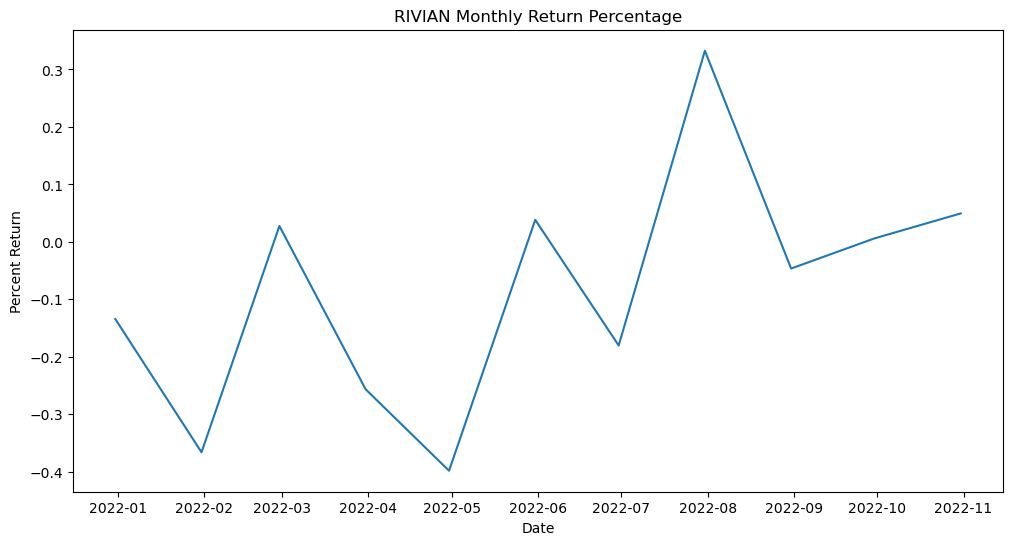

In [18]:
#Visualizing monthly return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_monthly_return)
plt.title('RIVIAN Monthly Return Percentage')
plt.show()

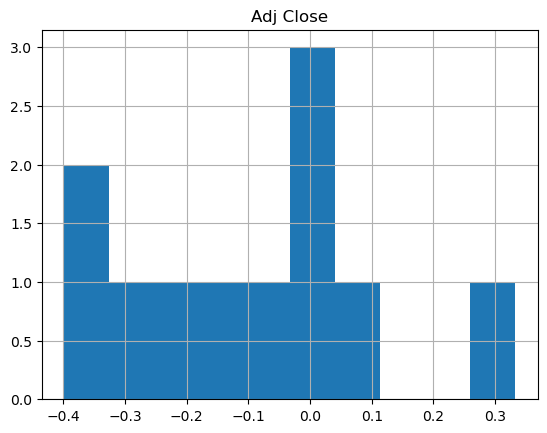

In [19]:
riv_monthly_return.hist();

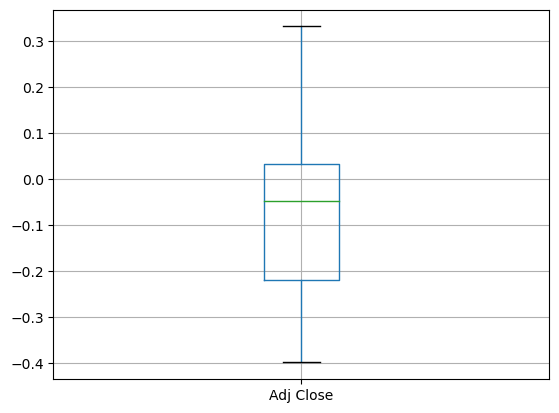

In [20]:
riv_monthly_return.boxplot();

In [21]:
# https://blog.devgenius.io/how-to-calculate-the-daily-returns-and-volatility-of-a-stock-with-python-d4e1de53e53b
#Calculating Volatility
daily_volatility_rivn = riv_daily_return['Adj Close'].std()
print('Daily volatility: \n --------------')
print('Rivian: ', '{:.2f}%'.format(daily_volatility_rivn))
print('\n')
monthly_volatility_rivn = math.sqrt(21) * daily_volatility_rivn
print('Monthly volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(monthly_volatility_rivn))
print('\n')
annual_volatility_rivn = math.sqrt(252) * daily_volatility_rivn
print('Annual volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(annual_volatility_rivn ))

Daily volatility: 
 --------------
Rivian:  0.06%


Monthly volatility: 
 --------------
Rivian:  0.28%


Annual volatility: 
 --------------
Rivian:  0.97%


In [22]:
# Creating function for assessment
def test_trend(ts_df):
    #Getting rolling statistics
    roll_mean = ts_df.rolling(11).mean()
    roll_std = ts_df.rolling(11).std()
    #Plotting rolling statistics
    fig = plt.figure(figsize=(12,7))
    plt.plot(ts_df, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print("Results of the Dickey-Fuller Test")
    dftest = adfuller(ts_df)
    # Output for dickey-fuller test will give us the values without defining what the values are.
    # Manually writing the values
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in dftest[4].items():
        dfoutput['critical value (%s)'%key] =  values
    print(dfoutput)

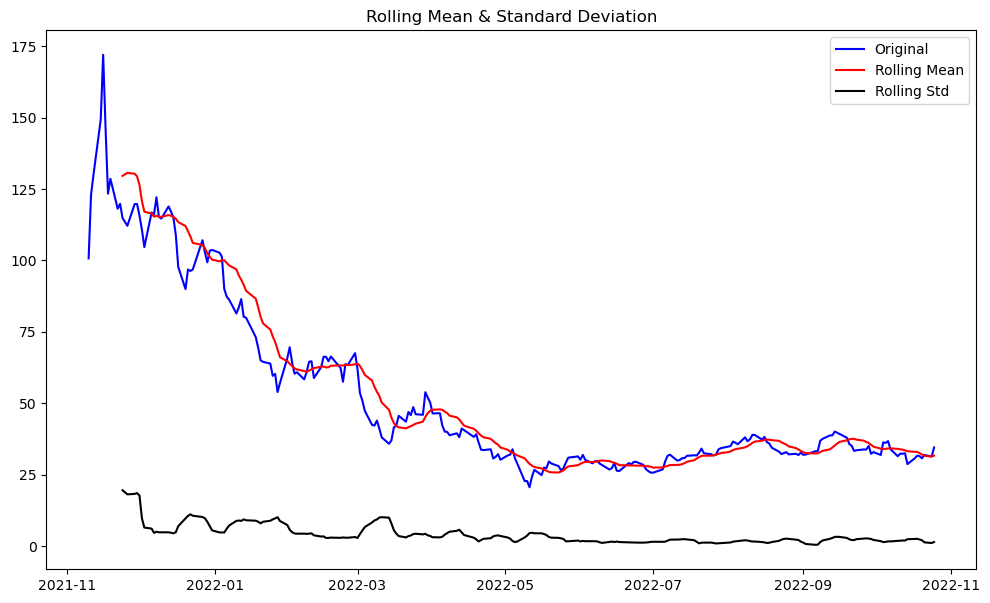

Results of the Dickey-Fuller Test
Test Statistics                 -3.210784
p-value                          0.019369
No. of lags used                 8.000000
Number of observations used    232.000000
critical value (1%)             -3.458855
critical value (5%)             -2.874080
critical value (10%)            -2.573453
dtype: float64


In [23]:
test_trend(riv_df_close)